## Midterm 1

In [1]:
%matplotlib inline

import cv2
import numpy as np
from matplotlib import pyplot as plt

import warnings 
warnings.filterwarnings('ignore')

First of all, I defined some helper functions that I used to compute a task for the LoG filter and convolution. <br>
*create_grid* allows creating a grid with (x,y) size. This function is used to create the kernel with LoG filter. <br>
*padding_reflect* pads an image with the *'reflect'* mode. The function is needed to pad the image because during the convolution we loss some pixels, indeed with this function I can preserve the original size of image. This helper function can be easily implemented using the function *numpy.pad(array, pad_width, mode='reflect', \**kwargs)* <br>
*show_image* easily show the image.

In [2]:
'''
create_grid
args: x - row size
      y - column size
'''
def create_grid(x, y):
    i_x = np.zeros(shape=(len(x), len(x)))
    i_y = np.zeros(shape=(len(y), len(y)))

    for i in range(len(x)):
        for j in range(len(x)):
            i_x[i, j] = x[j]
        
    for i in range(len(y)):
        for j in range(len(y)):
            i_y[i, j] = y[i]
    
    return i_x, i_y   

In [3]:
'''
padding_reflect
args: img - image to pad
      tuple_row_size - row size
      tuple_column_size - column size
'''
def padding_reflect(img, tuple_row_size, tuple_column_size):
    size_res_column = img.shape[1] + tuple_column_size[0] + tuple_column_size[1]
    size_res_row = img.shape[0] + tuple_row_size[0] + tuple_row_size[1]
    
    res = np.zeros(shape=(size_res_row, size_res_column))  
    
    index_i = 0
    flipped_i = False
    for i in range(tuple_row_size[0], size_res_row):
        index_j = 0   
        flipped = False    
        
        for j in range(tuple_column_size[0], size_res_column):
            res[i, j] = img[index_i, index_j]
            if index_j == (img.shape[1] - 1):
                flipped = True
            elif index_j == 0:
                flipped = False
            
            if flipped:
                index_j = index_j - 1            
            else:  
                index_j = index_j + 1  
    
        index_j = 0
        flipped = False
        for j in range(tuple_column_size[0], -1, -1):
            res[i, j] = img[index_i, index_j]
            if index_j == (img.shape[1] - 1):
                flipped = True
            elif index_j == 0:
                flipped = False
            
            if flipped:
                index_j = index_j - 1            
            else:  
                index_j = index_j + 1
        
        if index_i == (img.shape[0] - 1):
                flipped_i = True
        elif index_i == 0:
                flipped_i = False
        
        if flipped_i:
                index_i = index_i - 1           
        else:  
                index_i = index_i + 1
    
    index_i = 0 
    flipped_i = False
    for i in range(tuple_row_size[0], -1, -1):
        index_j = 0   
        flipped = False    
        for j in range(tuple_column_size[0], size_res_column):
            res[i, j] = img[index_i, index_j]
            if index_j == (img.shape[1] - 1):
                flipped = True
            elif index_j == 0:
                flipped = False
            
            if flipped:
                index_j = index_j - 1            
            else:  
                index_j = index_j + 1        
    
        index_j = 0
        flipped = False
        for j in range(tuple_column_size[0], -1, -1):
            res[i, j] = img[index_i, index_j]
            if index_j == (img.shape[1] - 1):
                flipped = True
            elif index_j == 0:
                flipped = False
            
            if flipped:
                index_j = index_j - 1            
            else:  
                index_j = index_j + 1
        
        if index_i == (img.shape[0] - 1):
                flipped_i = True
        elif index_i == 0:
                flipped_i = False
        
        if flipped_i:
                index_i = index_i - 1           
        else:  
                index_i = index_i + 1
       
    return res

In [4]:
'''
show_image
args: path - path where locate the image
'''
def show_image(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.show()

*LoG* function creates a LoG kernel to use for convolution. <br>
I defined the size of kernel searching a good *n* and the best option seems *(6\*sigma)* + 1 and to generate the kernel I used the Laplacian of Gaussian formula. This option allows good results in terms of time.

In [5]:
'''
LoG
args: sigma - scale parameter
returns: log_filter - filter of a size (6 * sigma) + 1
'''
def LoG(sigma):
    #define kernel size
    n = 2 * np.ceil(3 * sigma) + 1
    x = np.arange(-n // 2, n // 2 + 1, 1) 
    y = np.arange(-n // 2, n // 2 + 1, 1)
    
    #create the grid
    X, Y = create_grid(x, y)
    
    #create the filter using LoG formula
    log_filter =  (1/(2*np.pi*sigma**4)) * ( -(2.*sigma**2) + (X**2 + Y**2) ) *  (np.exp( -( (X**2+Y**2) / (2.*sigma**2) ) ))
    return log_filter

*convolve_log* function implements the convolution using the LoG filter. <br>
Before applying the convolution I pad the image and I used the 'reflect' method because with this can achieve better results with respect to other methods. For example, if I pad with a constant value, I get an image with a bright blob on the borders. <br>
So, apply the *convolution* with the sum of element-wise multiplication between kernel and neighborhood that the kernel covers of the input image.

In [6]:
'''
convolve_log
args: img - image to apply the convolution
      kernel - LoG kernel
'''
def convolve_log(img, kernel):    
    half_k_size = kernel.shape[0] // 2    
    img = padding_reflect(img, (half_k_size, half_k_size), (half_k_size, half_k_size)) #img = np.pad(img, ((half_k_size, half_k_size), (half_k_size, half_k_size)), 'reflect')
    
    k_size = kernel.shape[0]
    conv_height = img.shape[0] - k_size + 1
    conv_width = img.shape[1] - k_size + 1 

    # matrix of zeros
    convolved_img = np.zeros(shape=(conv_height, conv_width))
    
    for i in range(conv_height):
        for j in range(conv_width):
            # get the current matrix
            mat = img[i:i+k_size, j:j+k_size]
            
            # apply the convolution and store the result to i-th row and j-th column of our convolved_img array
            convolved_img[i, j] = np.sum(np.multiply(mat, kernel))
            
    return convolved_img

*LoG_convolution* function creates the LoG kernel and convolves the image. Given that I assumed the blobs must be light on a dark background, after the convolution I have raised to the power of two the convoluted image. 

In [7]:
'''
LoG_convolution
args: img - image to apply the convolution with LoG filter
      sigma - scale parameter
'''
def LoG_convolution(img, sigma):
    filter_log = LoG(sigma)
    res = convolve_log(img, filter_log)
    res = np.power(res, 2)
    
    return res

I created the *plot_scales* function to plot different choices of the scale parameter. In my case, I chose to plot nine images with different sigmas where sigma is computed with a simple power function.

In [8]:
'''
plot_scales
args: path - path where located the image
      k - base scale parameter
'''
def plot_scales(path, k):
    fig, axs = plt.subplots(3, 3, figsize=(20,20))
    img_gray = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    power_i = 0
    for i in range(0, 3):
        for j in range(0, 3):
            sigma = np.power(k,power_i)  
            res_img = LoG_convolution(img_gray, sigma)
            
            axs[i, j].imshow(res_img, cmap="gray")
            axs[i, j].set_title('sigma: %.3f' % sigma)
            power_i = power_i + 1
       
    for ax in axs.flat:
        ax.label_outer()
    plt.show()

The convolution of LoG of the blob detector shows the regions of an image. In detail, it smoothes edge and attenuates noise in an image, after that highlights region of rapid intensity change. <br>
In the example below, we can observe that the cows can be slightly recognized also with a high sigma.

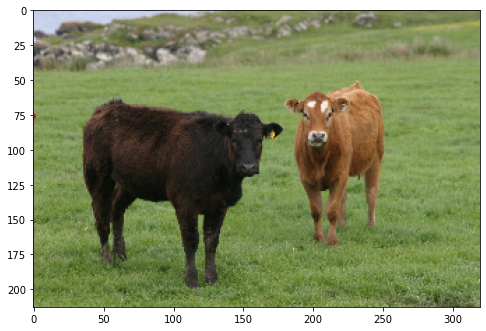

In [9]:
show_image("MSRC_ObjCategImageDatabase_v1/1_19_s.bmp")

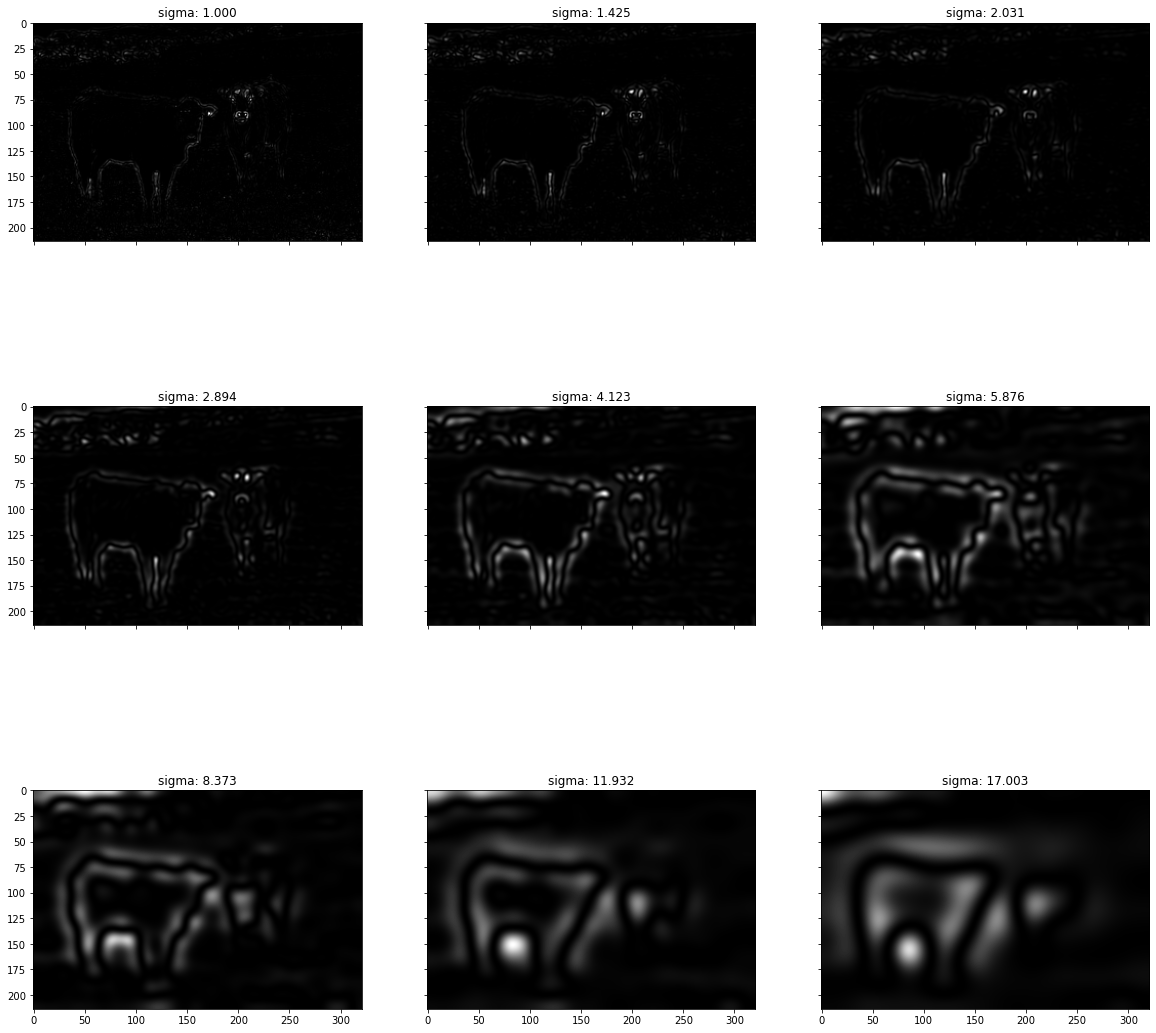

In [10]:
plot_scales("MSRC_ObjCategImageDatabase_v1/1_19_s.bmp", 1.425)

On another hand, in the second thematic class that I chose most of the pictures, increasing the sigma we lose completely the shape of object showed on the image. <br>
For example, the picture below shows that the sigma increases gradually losing the quality of the image, not recognizing the tree anymore.

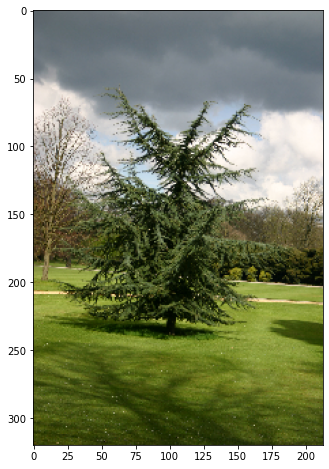

In [11]:
show_image("MSRC_ObjCategImageDatabase_v1/2_5_s.bmp")

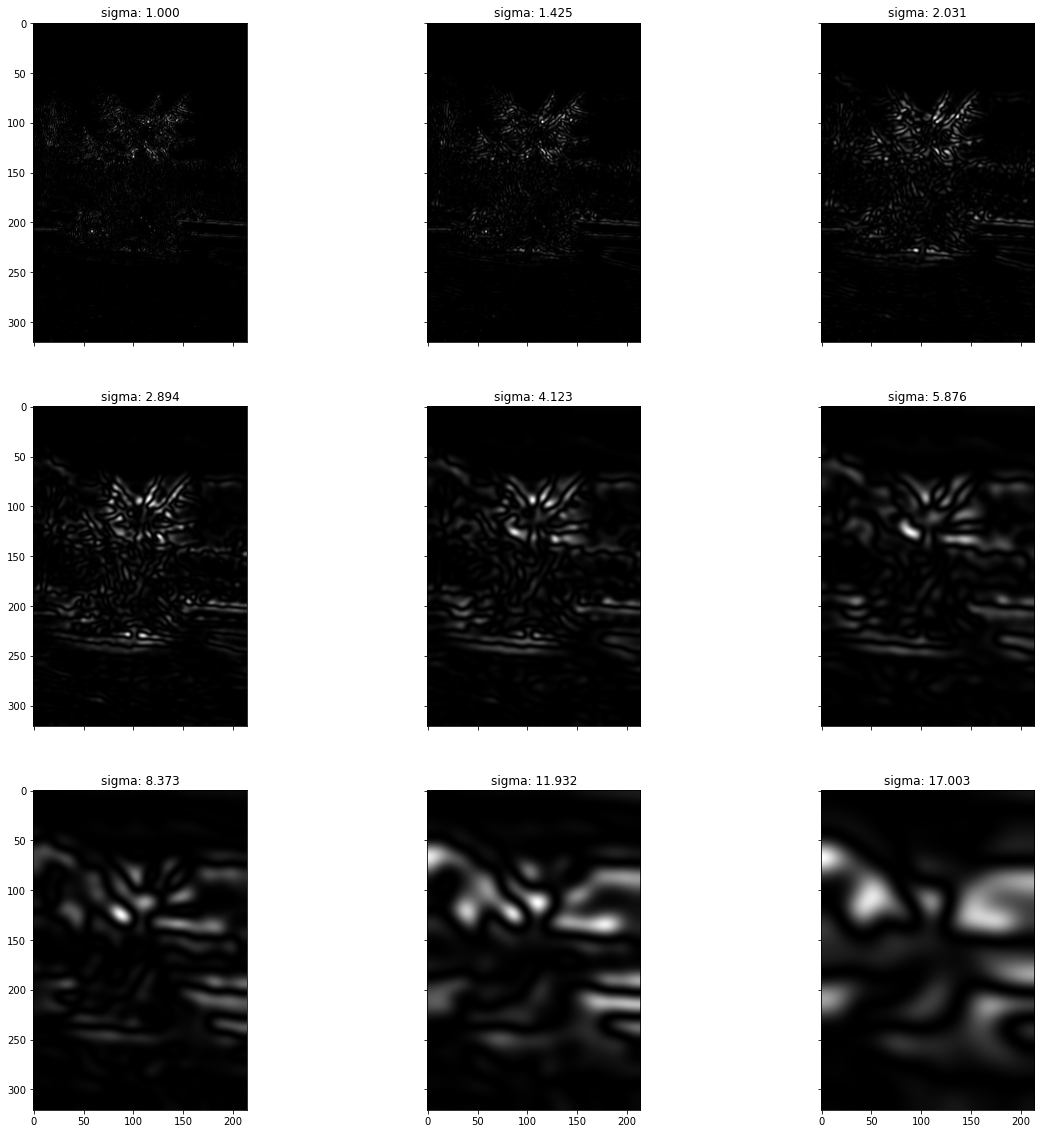

In [12]:
plot_scales("MSRC_ObjCategImageDatabase_v1/2_5_s.bmp",  1.425)

For human faces, LoG recognizes the regions that define well the shape of face maintaining, in some cases, the facial features, also with high sigma.

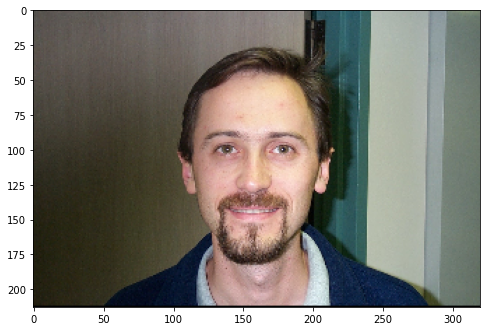

In [13]:
show_image("MSRC_ObjCategImageDatabase_v1/6_10_s.bmp")

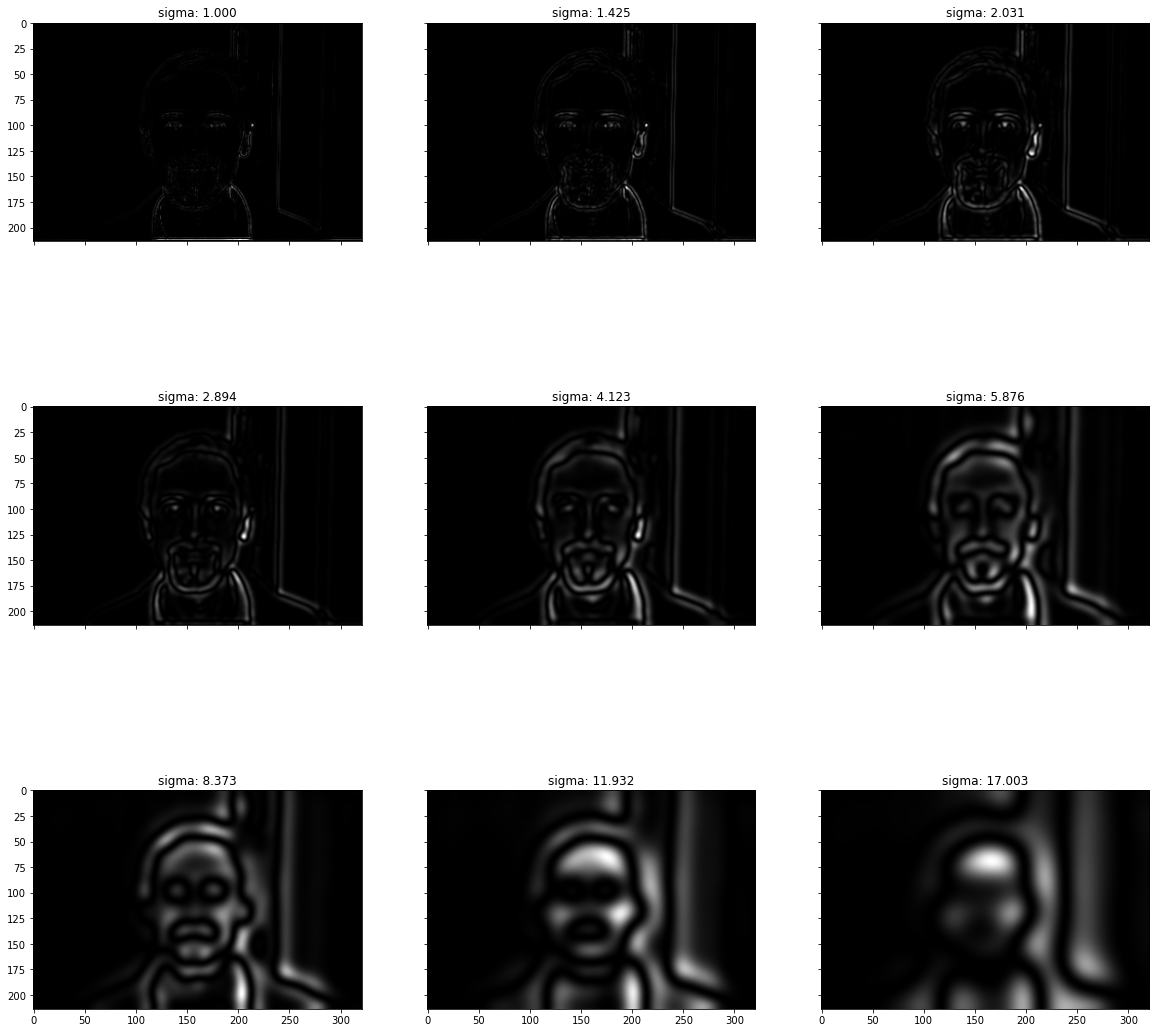

In [14]:
plot_scales("MSRC_ObjCategImageDatabase_v1/6_10_s.bmp",  1.425)

In the last image that I chose, the image does not detect well the light regions, especially with high sigma.

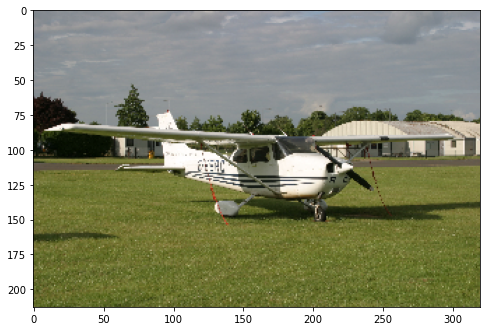

In [15]:
show_image("MSRC_ObjCategImageDatabase_v1/4_10_s.bmp")

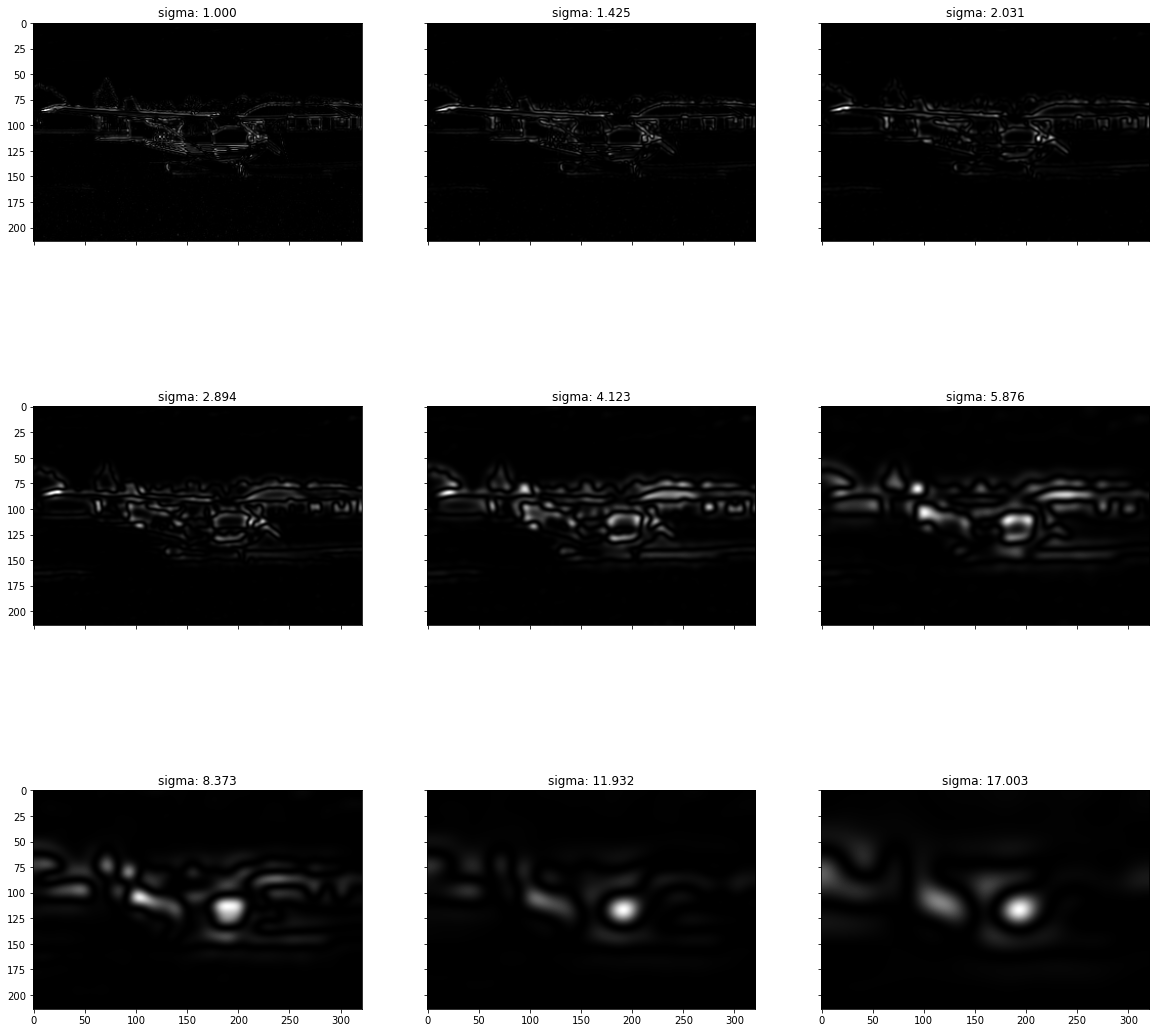

In [16]:
plot_scales("MSRC_ObjCategImageDatabase_v1/4_10_s.bmp",  1.425)

### Considerations

The convolution of Laplacian of Gaussian blob detector defines the regions in the image that are either brighter or darker than the surrounding.
Analyzing the different choices of the scale parameter, it is noticed that the larger sigma is the wider are the lines and the edges are smooth and more noise is ignored.
In addition, the picture becomes more chaotic and unrecognizable. <br>
In the analysis, we can notice that using a larger scale parameter can lose the quality of the picture so we can lose completely the shape of an object shown in the image. <br>
Other observations, not applying the padding if the scale parameter increases, the convolution losses more pixels in the image.
I tested with different dimensions of the kernel but it seems not to have peculiar differences, except for the running time. But, a valuable improvement could be to apply parallelized convolution for increasing efficiency and decreasing running time.

  

### Additional part

I wanted to detect the blobs creating some additional function *detect_blob* and *convolve_scales* where respectively:
- The first function allows to find the maximum peak of the matrix, in this case, it searches the maximum value of the matrix (i.e. images which have been applied the LoG convolution with different sigmas).
- The second function applies the convolution with the LoG filter with different scale parameters and returns all convoluted images.

In [17]:
from math import sqrt, acos, pi
from scipy import spatial

def detect_blob(img_cnv, size_img, sigma, threshold = 0.03):
    coord = []

    for i in range(1, size_img[0]):
        for j in range(1, size_img[1]):
            #slice for each matrix a 3x3 size
            slice_img = img_cnv[:,i-1:i+2,j-1:j+2]
            
            #find the maximum
            max_pixel = np.amax(slice_img)
            
            #ignored the maximum pixel that it is less than a threshold
            if max_pixel >= threshold:
                
                #get coordinates
                z,x,y = np.unravel_index(slice_img.argmax(),slice_img.shape)
                
                #store the coordinates of slice of image (3x3 matrix)
                coord.append( (i+x-1, j+y-1, sigma**z) )
    return coord

In [18]:
'''
convolve_scales
args: path - path where located the image
      k - base scale parameter
'''
def convolve_scales(path, k):
    img_gray = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img_gray = img_gray/255.0  #image normalization
    res = []

    for i in range(0, 9):
        sigma = np.power(k, i) 
        res_img = LoG_convolution(img_gray, sigma)
        res.append(res_img)

    out = np.array([i for i in res]) # storing the output in numpy array
    return out

But, it needs additional functions to handle the blobs overlap and the two functions below allow to reduce the overlap.
Searching the area of overlap between blobs and if this area is greater than a certain threshold, the blob with the smaller radius will be deleted.

In [19]:
def blob_overlap(blob1, blob2):
    n_dim = len(blob1) - 1
    root_ndim = sqrt(n_dim)

    # radius of two blobs
    r1 = blob1[-1] * root_ndim
    r2 = blob2[-1] * root_ndim
    
    d = sqrt(np.sum((blob1[:-1] - blob2[:-1])**2))
    
    #no overlap between two blobs
    if d > r1 + r2:
        return 0
    # one blob is inside the other, the smaller blob must die
    elif d <= abs(r1 - r2):
        return 1
    else:
        #computing the area of overlap between blobs
        ratio1 = (d ** 2 + r1 ** 2 - r2 ** 2) / (2 * d * r1)
        ratio1 = np.clip(ratio1, -1, 1)
        acos1 = acos(ratio1)

        ratio2 = (d ** 2 + r2 ** 2 - r1 ** 2) / (2 * d * r2)
        ratio2 = np.clip(ratio2, -1, 1)
        acos2 = acos(ratio2)

        a = -d + r2 + r1
        b = d - r2 + r1
        c = d + r2 - r1
        d = d + r2 + r1

        area = (r1 ** 2 * acos1 + r2 ** 2 * acos2 -0.5 * sqrt(abs(a * b * c * d)))
        return area/(pi * (min(r1, r2) ** 2))
    

In [20]:
def redundancy(blobs_array, overlap):
    sigma = blobs_array[:, -1].max()
    distance = 2 * sigma * sqrt(blobs_array.shape[1] - 1)
    tree = spatial.cKDTree(blobs_array[:, :-1])
    pairs = np.array(list(tree.query_pairs(distance)))
    if len(pairs) == 0:
        return blobs_array
    else:
        for (i, j) in pairs:
            blob1, blob2 = blobs_array[i], blobs_array[j]
            if blob_overlap(blob1, blob2) > overlap:
                if blob1[-1] > blob2[-1]:
                    blob2[-1] = 0
                else:
                    blob1[-1] = 0

    return np.array([b for b in blobs_array if b[-1] > 0])

In [21]:
log_test = convolve_scales("MSRC_ObjCategImageDatabase_v1/4_10_s.bmp", 1.425)

In [22]:
img_test = cv2.imread("MSRC_ObjCategImageDatabase_v1/4_10_s.bmp")
img_test = cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB)
coordinates_test = list(set(detect_blob(log_test, img_test.shape, 1.425)))

In [23]:
coordinates_test = np.array(coordinates_test)
coordinates_test = redundancy(coordinates_test, 0.2)

In the last cell, I drew the circles on the original image using the coordinates of the blobs detected previously for visualizing the regions on the picture. The result shows the blobs of different scales by detecting the local extrema of the LoG scale-space representation.

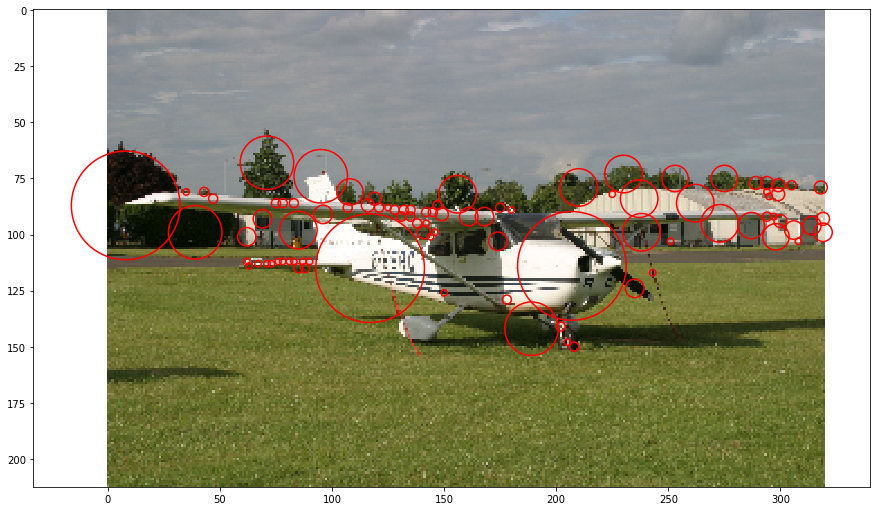

In [24]:
fig, ax = plt.subplots(figsize=(15,15))

ax.imshow(img_test, interpolation='nearest',cmap="gray")
for blob in coordinates_test:
    y,x,r = blob
    c = plt.Circle((x, y), r*1.425, color='red', linewidth=1.5, fill=False)
    ax.add_patch(c)

ax.plot() 
plt.show()